# Probabilistic Machine Learning with PyMC3: Part I
----

## Introduction to PyMC3
**PyMC3 is a Python package for Bayesian statistical modeling and Probabilistic Machine Learning focusing on advanced Markov chain Monte Carlo (MCMC) and variational inference (VI) algorithms.**

<img src="pymc3_logo.jpg" alt="PyMC3" width="25%" />
<figcaption>Image credit: http://docs.pymc.io/index.html.</figcaption>

First, let's set up our working environment including required libraries.

In [1]:
%matplotlib inline
from warnings import filterwarnings
filterwarnings("ignore")
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
os.environ['THEANO_FLAGS'] = 'device=cpu'

import numpy as np
import pandas as pd
import theano
import pymc3 as pm
import seaborn as sns             
import matplotlib.pyplot as plt

In [2]:
## Plotting settings
sns.set_context('notebook', font_scale = 1.1)
np.random.seed(12345)
rc = {'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 15, 'font.size': 20,
      'lines.linewidth': 4.0, 'lines.markersize': 40, 'font.family': "serif", 'font.serif': "cm",
      'savefig.dpi': 200, 'text.usetex': False, 'legend.fontsize': 20.0, 'axes.titlesize': 20, 
      "figure.figsize": [20, 12]}
sns.set(rc = rc)
sns.set_style("whitegrid") # or ticks

## Steps in Probabilistic Modeling

<img src="model_infer_criticize.png" alt="Box's Loop" width="75%" />
<figcaption>Box's Loop (Image credit: http://dustintran.com/).</figcaption>

### Step 1: Prepare the data

In [3]:
# create some data as a Numpy array or pandas df
# True parameter values
def create_dummy_data(alpha, sigma, beta, size):
    alpha, sigma = alpha, sigma
    beta = beta

    # Size of dataset
    size = size

    # Predictor variable
    X1 = np.random.randn(size) * 3
    X2 = np.random.randn(size) * 4

    # Simulate outcome variable
    Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma
    return X1, X2, Y

X1_train, X2_train, Y_train = create_dummy_data(alpha = 1, sigma = 2, beta = [4, 4.5], size = 50)
X1_test, X2_test, Y_test = create_dummy_data(alpha = 1, sigma = 2, beta = [4, 4.5], size = 100)

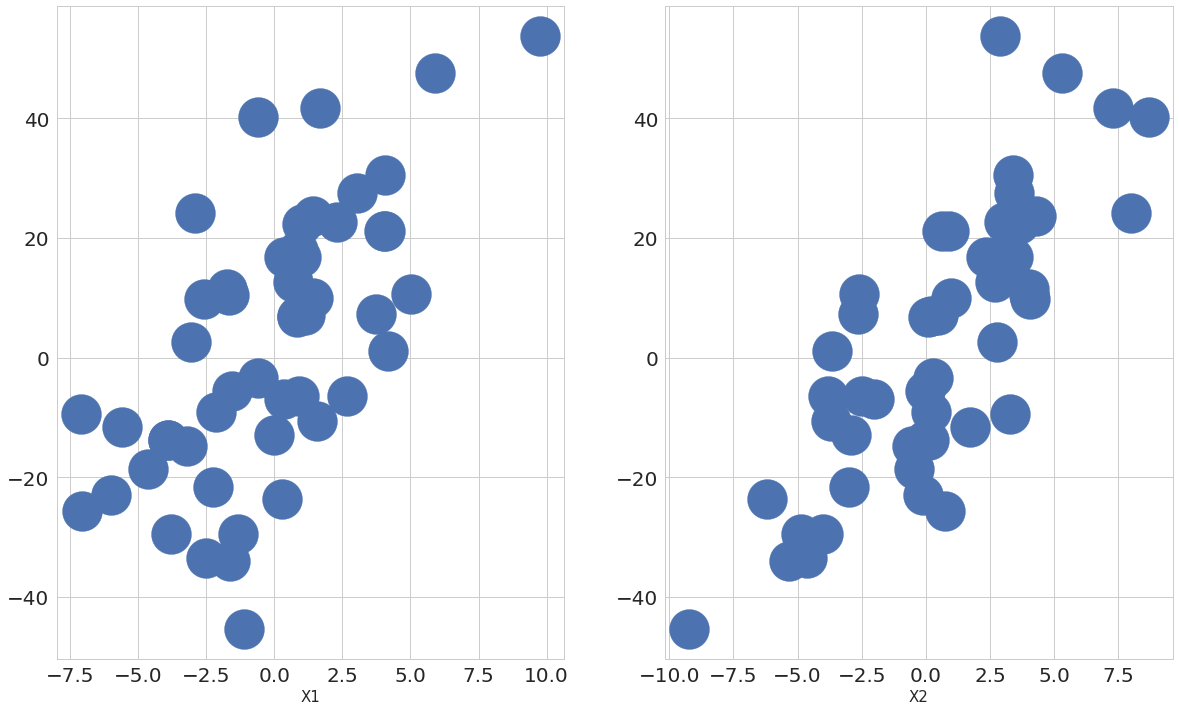

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(X1_train, Y_train)
ax2.scatter(X2_train, Y_train)
ax1.set_xlabel("X1")
ax2.set_xlabel("X2");

In [5]:
# PyMC3 uses theano.shared variables so as
# to be able to exchange the data the model runs on
X1_shared = theano.shared(X1_train)
X2_shared = theano.shared(X2_train)
Y_shared = theano.shared(Y_train)

### Step 2: Build the model

In [6]:
# instantiate a model using the pymc3 Model class
with pm.Model() as lm:
    
    # specify priors on unknown model parameters
    alpha = pm.Normal("alpha", mu = 1, sd = 0.5)
    beta1 = pm.Normal("beta1", mu = 4, sd = 0.5)
    beta2 = pm.Normal("beta2", mu = 4, sd = 0.5)
    sigma = pm.HalfCauchy("sigma", beta = 2)
    
    # specify the expected value mean
    mean = alpha + beta1*X1_shared + beta2*X2_shared
    
    # specify the likelihood of observations
    # data can be passed in as lists, numpy array, theano array and pandas df
    obs = pm.Normal("obs", mu = mean, sd = sigma, observed = Y_shared)

### Step 3: Perform inference

In [7]:
# sample from the posterior
with lm:     
    posterior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, beta2, beta1, alpha]
100%|██████████| 1000/1000 [00:01<00:00, 572.46it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '2591' (I am process '2592')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/jovyan/.theano/compiledir_Linux-4.9-linuxkit-aufs-x86_64-with-debian-stretch-sid-x86_64-3.6.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '2591' (I am process '2593')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/jovyan/.theano/compiledir_Linux-4.9-linuxkit-aufs-x86_64-with-debian-stretch-sid-x86_64-3.6.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '2592' (I am process '2593')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/jovyan/.theano/compiledir_Linux-4.9-linuxkit-aufs-x86_64-with-

### Step 4: Diagnose convergence of the MCMC chains

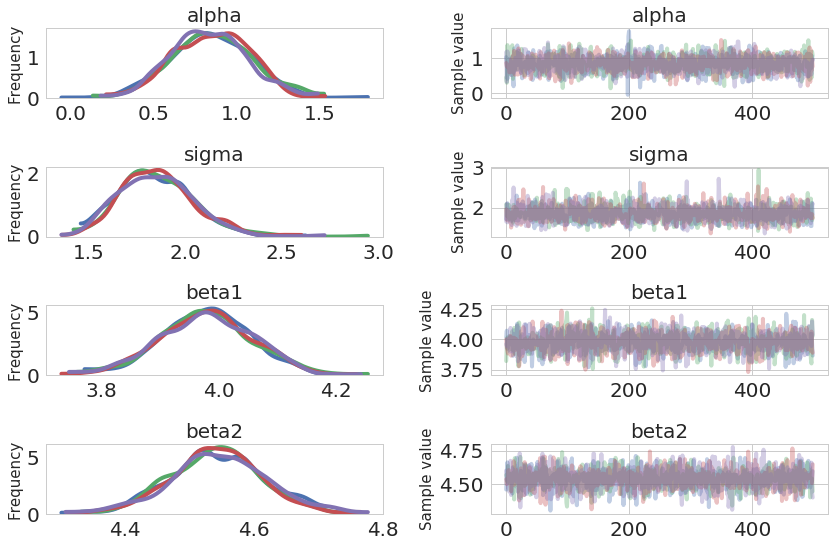

In [8]:
# a traceplot is the most common plot used to analyze sampling results
pm.traceplot(posterior, varnames = ["alpha", "sigma", "beta1", "beta2"]);

One way to monitor whether a chain has converged to the equilibrium distribution is to compare its behavior to other randomly initialized chains. This is the motivation for the Gelman and Rubin (1992) potential scale reduction statistic, R̂ . The R̂  statistic measures the ratio of the average variance of samples within each chain to the variance of the pooled samples across chains; if all chains are at equilibrium, these will be the same and R̂  will be one. If the chains have not converged to a common distribution, the R̂  statistic will be greater than one. (Stan Development Team, 2016).

In [9]:
# also look at the Gelman-Rubin statistic
pm.gelman_rubin(posterior, varnames = ["alpha", "sigma", "beta1", "beta2"])

{'alpha': 1.0002337053296397,
 'beta1': 0.9990149946207174,
 'beta2': 1.000113552109643,
 'sigma': 1.0000783707196865}

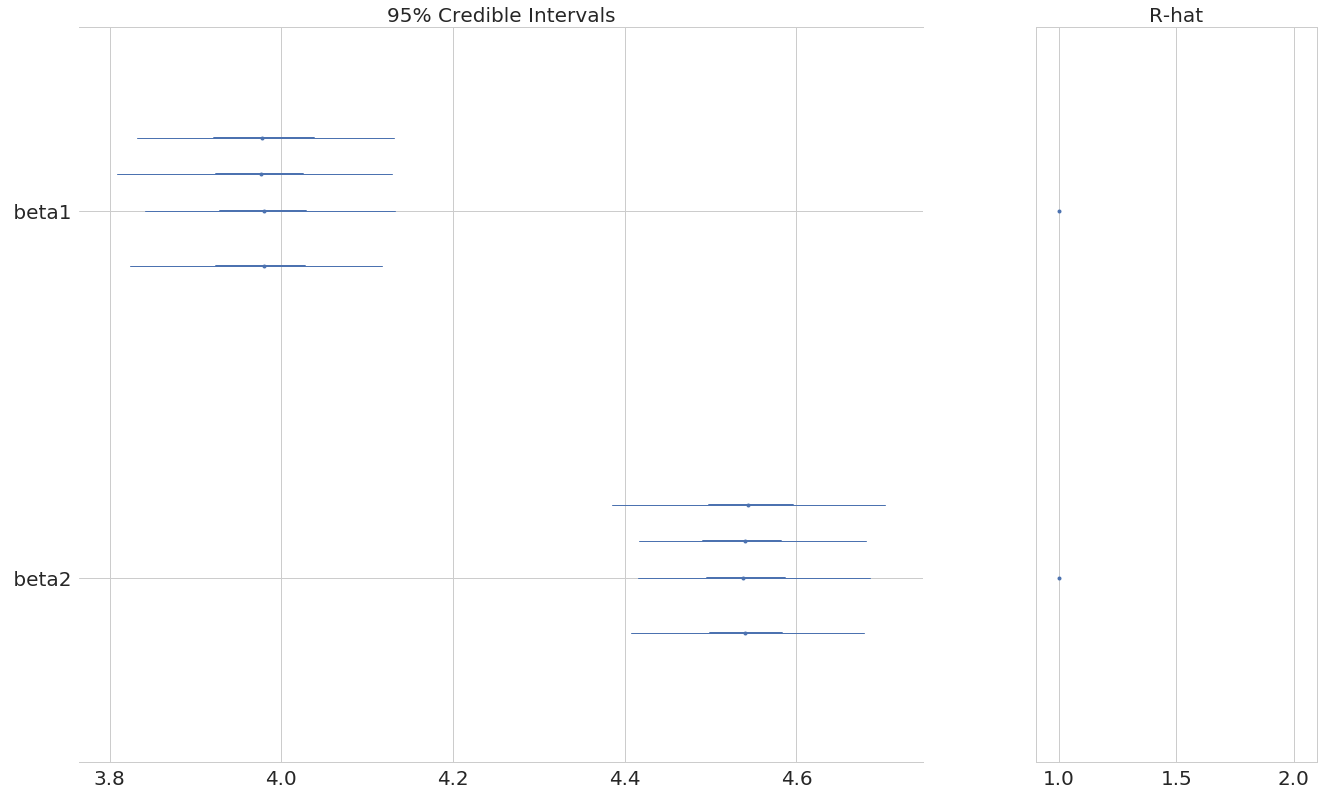

In [10]:
# also look at the forestplot for Rhat values
pm.forestplot(posterior, varnames = ["beta1", "beta2"]);

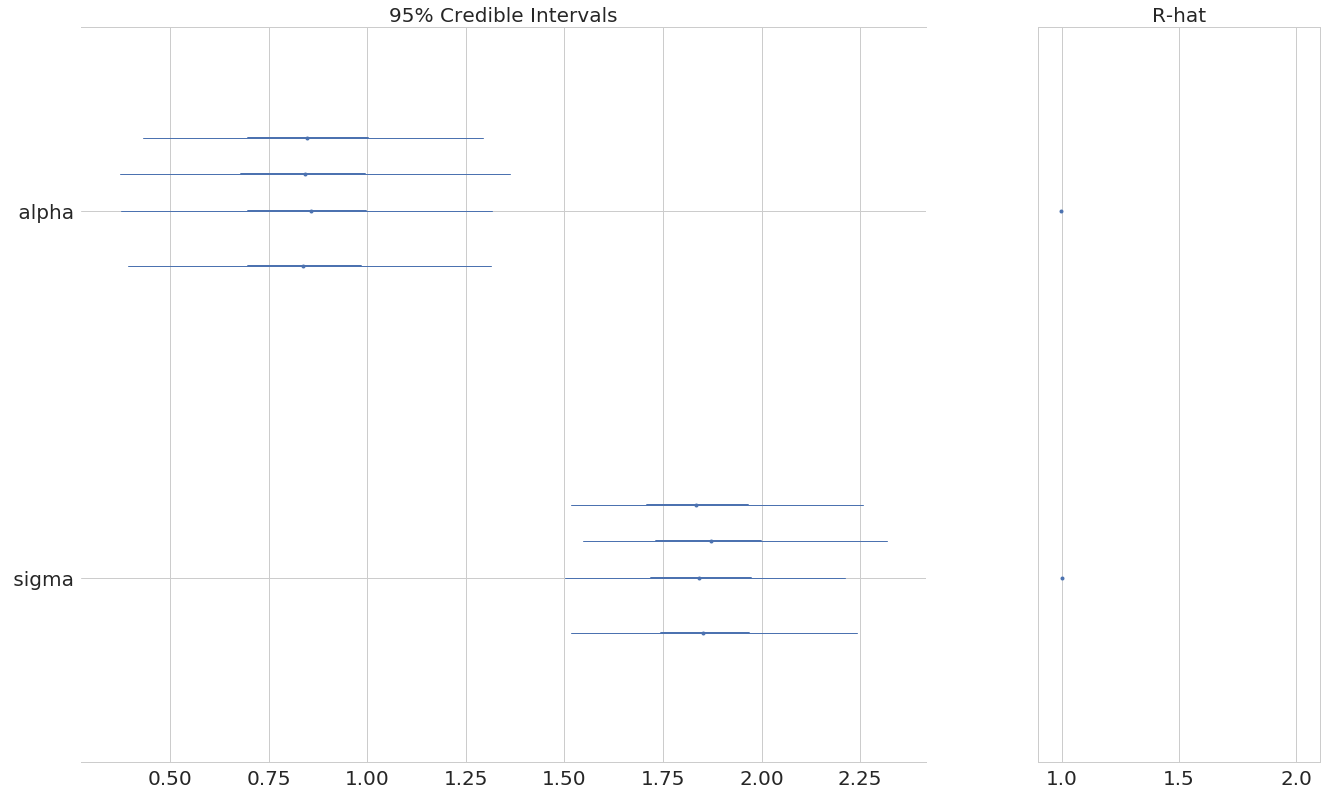

In [11]:
pm.forestplot(posterior, varnames = ["alpha", "sigma"]);

### Step 5: Critize the model

In [11]:
pm.summary(posterior, varnames = ["alpha", "sigma", "beta1", "beta2"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.842042,0.233539,0.004854,0.401399,1.307556,2395.382757,1.000234
sigma,1.854358,0.189703,0.004308,1.502608,2.215065,2139.545016,1.000078
beta1,3.978154,0.078216,0.001692,3.829171,4.132768,2150.154071,0.999015
beta2,4.540840,0.071435,0.001488,4.403797,4.684492,2680.345536,1.000114


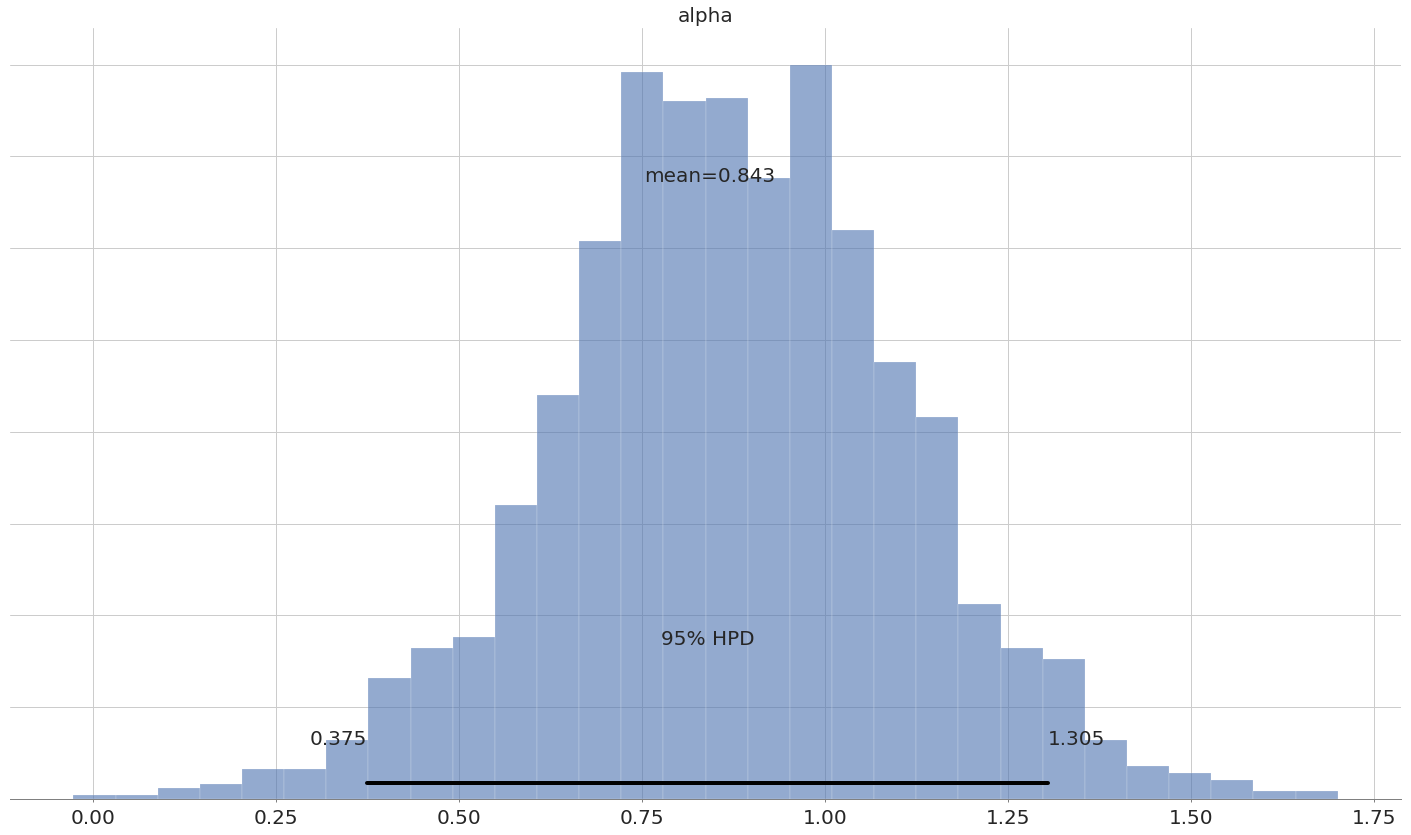

In [13]:
pm.plot_posterior(posterior, varnames = ["alpha"], alpha = 0.6);

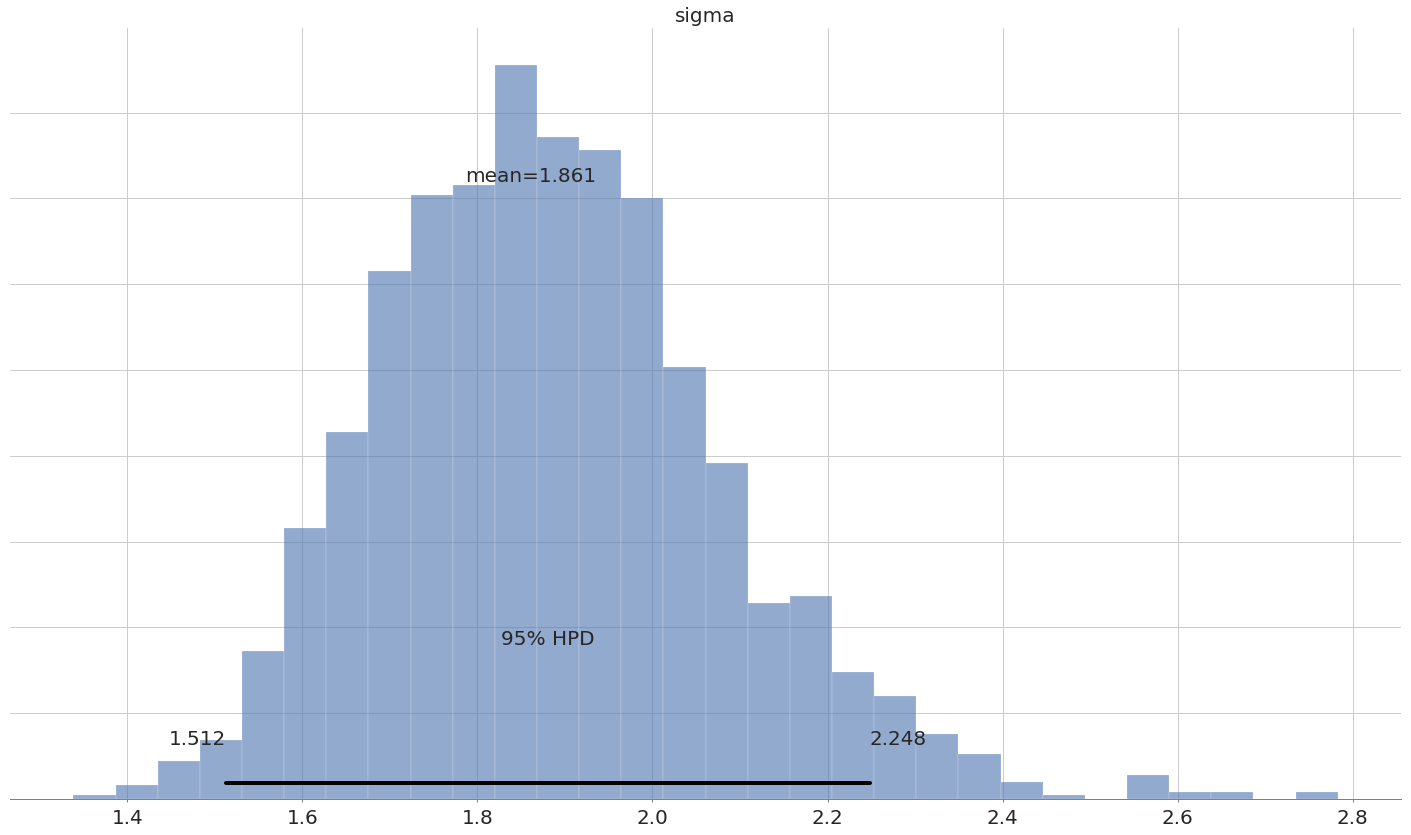

In [14]:
pm.plot_posterior(posterior, varnames = ["sigma"], alpha = 0.6);

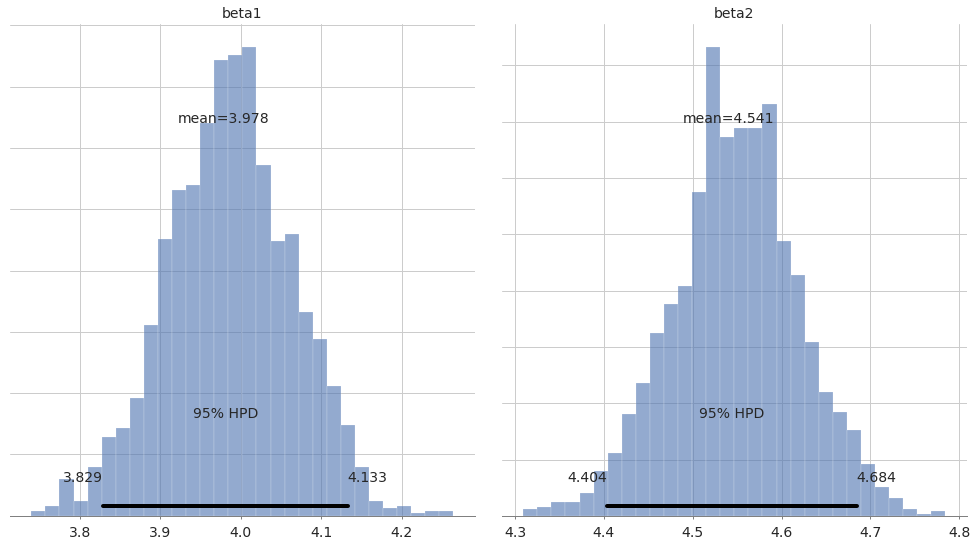

In [12]:
pm.plot_posterior(posterior, varnames = ["beta1", "beta2"], figsize = [14, 8], alpha = 0.6);

In [13]:
# Posterior predictive checks (PPCs) are a great way to validate the model
# i.e to check how data generated from the model deviates from the true distribution
# PPC involves generating data from the model using estimated parameters from the posterior
# use pm.sample_ppc to do posterior predictive checks
with lm:
    post_pred = pm.sample_ppc(posterior, samples = 1000)

100%|██████████| 1000/1000 [00:00<00:00, 1614.24it/s]


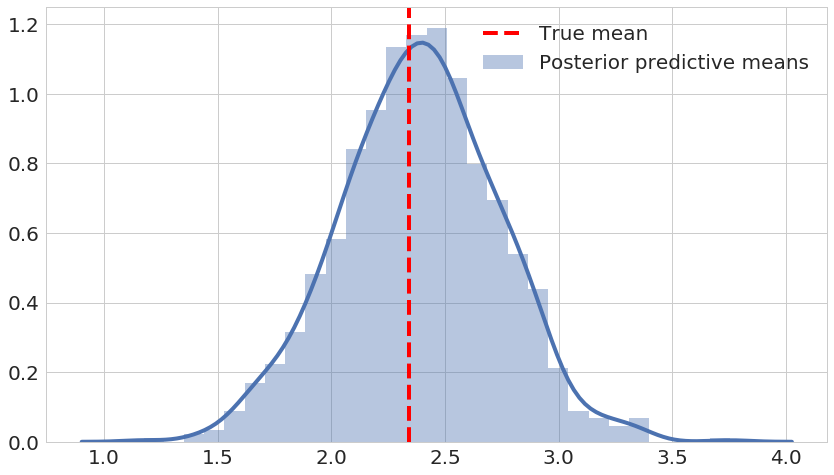

In [14]:
plt.figure(figsize = [14, 8])
ax = sns.distplot(post_pred['obs'].mean(axis=1), label='Posterior predictive means')
ax.axvline(Y_train.mean(), color='r', ls='--', label='True mean')
ax.legend();

#### Generate more data

In [15]:
# generate more data
X1_train_new, X2_train_new, Y_train_new = create_dummy_data(alpha = 1, sigma = 2, beta = [4, 4.5], size = 1000)

# Changing values here will also change values in the model
X1_shared.set_value(X1_train_new); X2_shared.set_value(X2_train_new); Y_shared.set_value(Y_train_new)

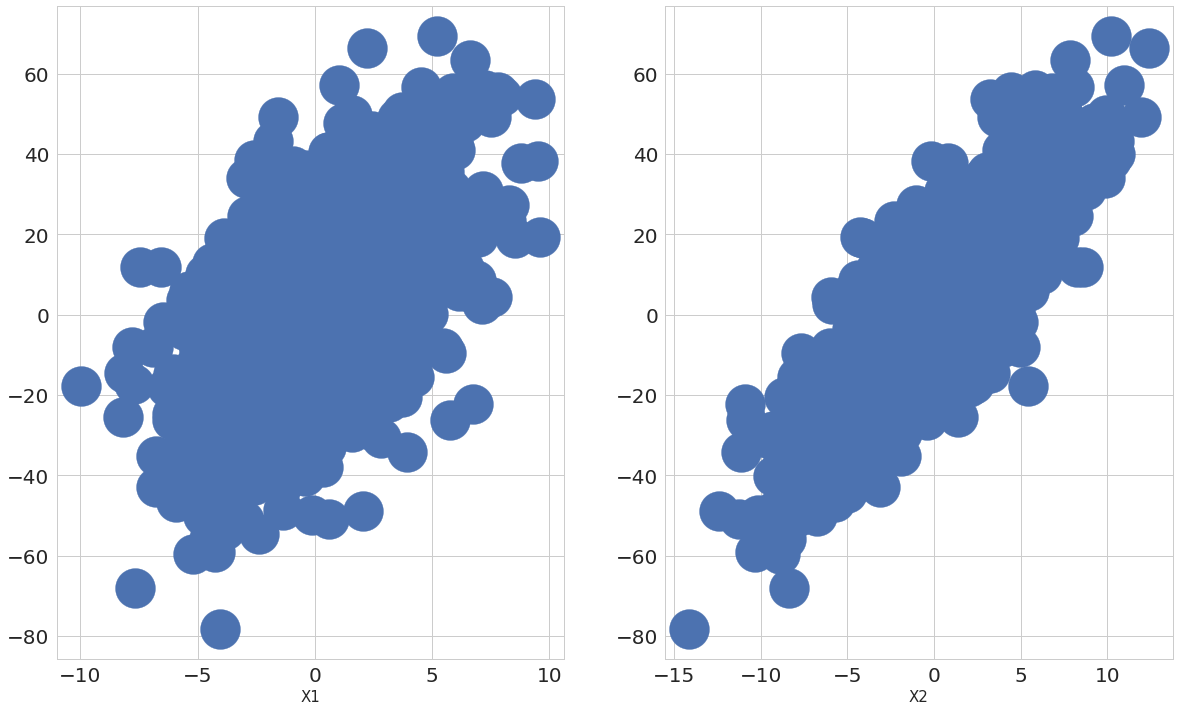

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(X1_train_new, Y_train_new)
ax2.scatter(X2_train_new, Y_train_new)
ax1.set_xlabel("X1")
ax2.set_xlabel("X2");

#### Improve the model
Use posterior from previous iteration as prior for the next one.

In [27]:
from update_prior import from_posterior
posterior_new = [posterior]

# instantiate a model using the pymc3 Model class
with pm.Model() as updated_lm:

    # specify priors on unknown model parameters
    # Priors are posteriors from previous iteration
    alpha = from_posterior("alpha", posterior["alpha"])
    beta1 = from_posterior("beta1", posterior["beta1"])
    beta2 = from_posterior("beta2", posterior["beta2"])
    sigma = from_posterior("sigma", posterior["sigma"])

    # specify the expected value mean
    mean = alpha + beta1*X1_shared + beta2*X2_shared

    # specify the likelihood of observations
    # data can be passed in as lists, numpy array, theano array and pandas df
    obs = pm.Normal("obs", mu = mean, sd = sigma, observed = Y_shared)

    step = pm.NUTS(target_accept = 0.999, adapt_step_size = 0.001, max_treedepth = 15)
    posterior = pm.sample(1000, step = step)
    posterior_new.append(posterior)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_interval__, beta2_interval__, beta1_interval__, alpha_interval__]
100%|██████████| 1500/1500 [00:29<00:00, 50.99it/s]


Posterior distributions after 2 iterations.


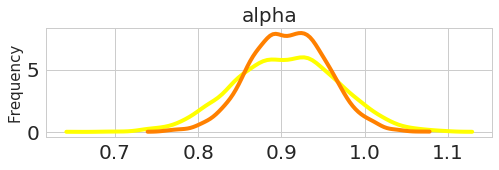

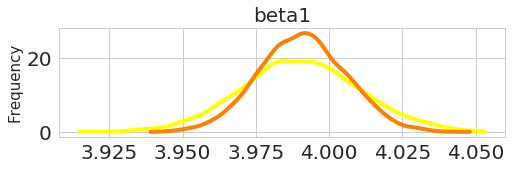

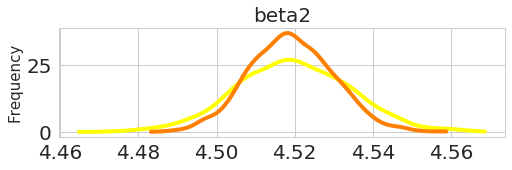

In [28]:
print('Posterior distributions after ' + str(len(posterior_new)) + ' iterations.')
cmap = plt.cm.autumn
from scipy import stats
for param in ['alpha', 'beta1', 'beta2']:
    plt.figure(figsize=(8, 2))
    for update_i, posterior in enumerate(posterior_new):
        samples = posterior[param]
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples)(x)
        plt.plot(x, y, color=cmap(1 - update_i / len(posterior_new)))
#     plt.axvline({'alpha': alpha, 'beta1': beta[0], 'beta2': beta[1]}[param], c='k')
    plt.ylabel('Frequency')
    plt.title(param)
    plt.show()

### Step 6: Use the model for prediction

In [29]:
# use pm.sample_ppc to do prediction on hold-out or unseen data  
# for hold-out or unseen data, pymc3 uses theano.shared variables so as
# to be able to exchange the data the model runs on

# Changing values here will also change values in the model
X1_shared.set_value(X1_test); X2_shared.set_value(X2_test)

# Simply running PPC will use the updated values and do prediction
with updated_lm:
    post_pred_test = pm.sample_ppc(posterior_new, samples = 1000)    

100%|██████████| 1000/1000 [01:09<00:00, 14.40it/s]


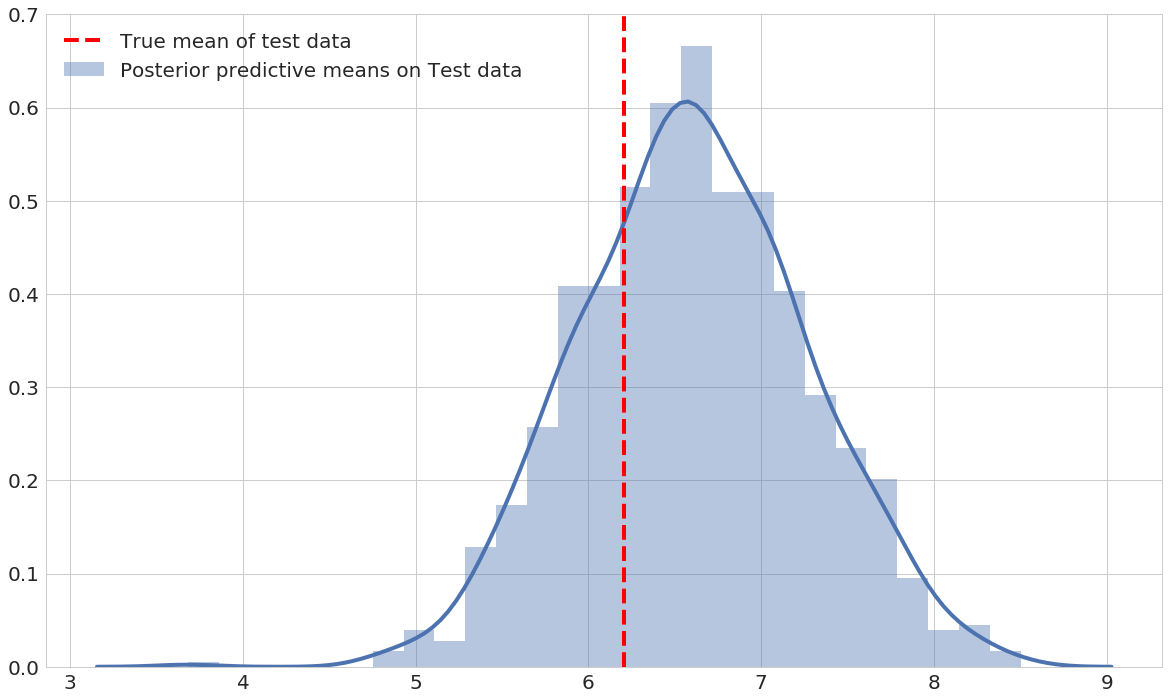

In [30]:
plt.figure()
ax = sns.distplot(post_pred_test['obs'].mean(axis=1), 
                  label='Posterior predictive means on Test data')
ax.axvline(Y_test.mean(), color='r', ls='--', label='True mean of test data')
ax.legend();

In [ ]:
df = pd.DataFrame({"predicted" : post_pred_test["obs"].mean(axis = 0), 
              "observed" : Y_test})
df["error"] = (df.observed - df.predicted)
rmse = np.sqrt(np.mean((df.observed - df.predicted)**2))
rmse

## Dependencies

In [ ]:
# Dependencies
%load_ext watermark
%watermark -dmvgp numpy,scipy,pandas,matplotlib,seaborn,patsy,pymc3,theano,joblib